In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (2).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000115 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000112.png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (5).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000117 (6).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000114 (4).png
/kaggle/input/chest-ctscan-images/Data/valid/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa/000118 (4).png
/kaggle/input/chest-cts

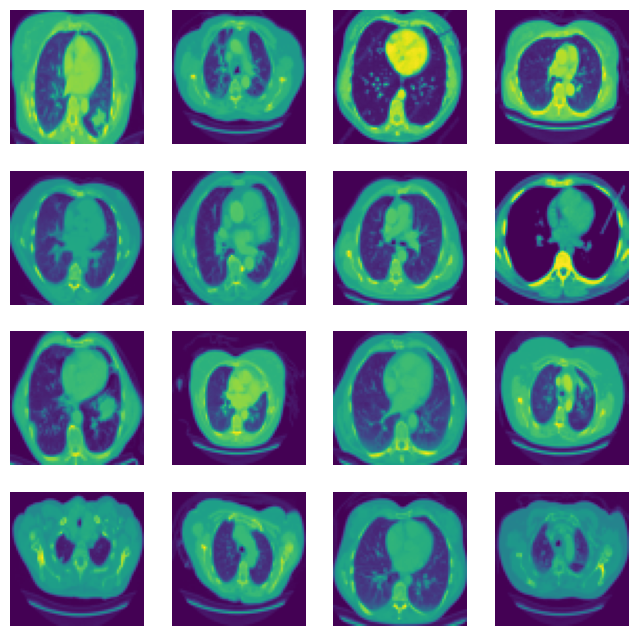

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),  # Resize images to 64x64
    
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1] range
])

# Load dataset
dataset = ImageFolder(root='/kaggle/input/chest-ctscan-images/Data', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Get a batch of images
dataiter = iter(dataloader)
images, _ = next(dataiter)

# Convert from [-1,1] to [0,1] for visualization
images = (images + 1) / 2

# Plot images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')

plt.show()


## Making a Discriminator

In [4]:


# Define the discriminator network
discriminator = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(p=0.2),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(p=0.2),
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(p=0.2),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout(p=0.2),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
    nn.Sigmoid()  # Output probability [0,1]
)

# Test with a batch of fake images (batch_size=64, 3 channels, 64x64)
fake_images = torch.randn(64, 1, 64, 64)

# Forward pass
outputs = discriminator(fake_images).view(-1, 1)

print(outputs.shape)  # Should print: torch.Size([64, 1])

torch.Size([64, 1])



**Discriminator Model:** 

Uses Conv2d layers to downscale the image from 64x64x3 to a single probability output.
LeakyReLU(0.2) prevents dying gradients.
Dropout(0.2) helps regularization.
Sigmoid ensures the output is between [0,1].

## Making a Generator

In [5]:
import torch
import torch.nn as nn

# Define the generator network
generator = nn.Sequential(
    nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
    nn.Tanh()  # Outputs values between [-1, 1]
)

# Test with a batch of random noise (batch_size=64, noise_dim=100, 1, 1)
noise = torch.randn(64, 100, 1, 1)

# Generate fake images
fake_images = generator(noise)

print(fake_images.shape)  # Should print: torch.Size([64, 3, 64, 64])


torch.Size([64, 1, 64, 64])


**Generator Model:**

Uses ConvTranspose2d layers to progressively upscale a random noise vector (100x1x1) into a 64x64x3 image.
BatchNorm2d stabilizes training.
ReLU is used for activations, with Tanh in the final layer for image output.

Epoch [1/500], Step [0/16], D Loss: 1.4302, G Loss: 1.0714


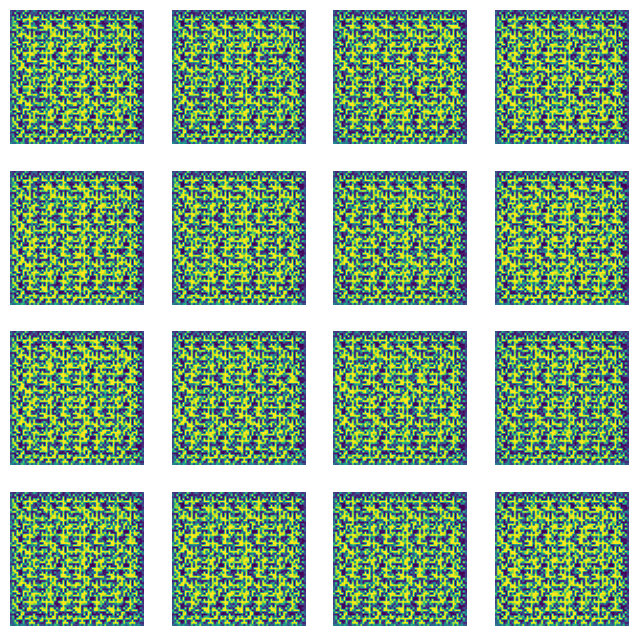

Epoch [2/500], Step [0/16], D Loss: 0.0438, G Loss: 5.5331
Epoch [3/500], Step [0/16], D Loss: 0.0408, G Loss: 6.8315
Epoch [4/500], Step [0/16], D Loss: 0.0302, G Loss: 9.3788
Epoch [5/500], Step [0/16], D Loss: 0.5290, G Loss: 14.6767
Epoch [6/500], Step [0/16], D Loss: 0.1898, G Loss: 5.7463


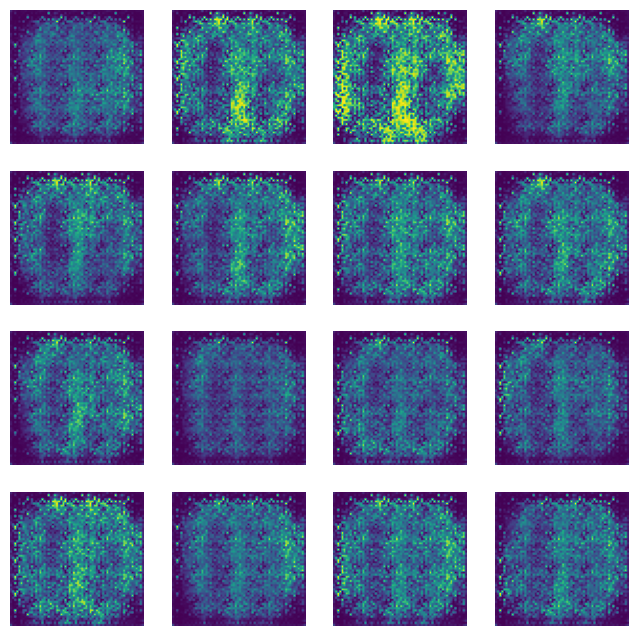

Epoch [7/500], Step [0/16], D Loss: 0.6310, G Loss: 0.8445
Epoch [8/500], Step [0/16], D Loss: 0.9436, G Loss: 2.8423
Epoch [9/500], Step [0/16], D Loss: 1.1889, G Loss: 3.8390
Epoch [10/500], Step [0/16], D Loss: 0.4086, G Loss: 3.3236
Epoch [11/500], Step [0/16], D Loss: 0.4269, G Loss: 3.6626


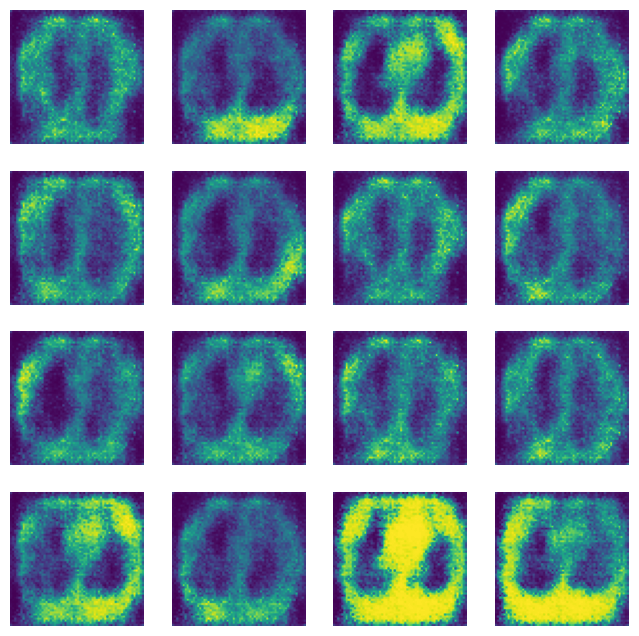

Epoch [12/500], Step [0/16], D Loss: 0.3079, G Loss: 3.6772
Epoch [13/500], Step [0/16], D Loss: 0.3455, G Loss: 2.8959
Epoch [14/500], Step [0/16], D Loss: 0.5664, G Loss: 3.1525
Epoch [15/500], Step [0/16], D Loss: 0.8468, G Loss: 1.5474
Epoch [16/500], Step [0/16], D Loss: 0.4439, G Loss: 3.7421


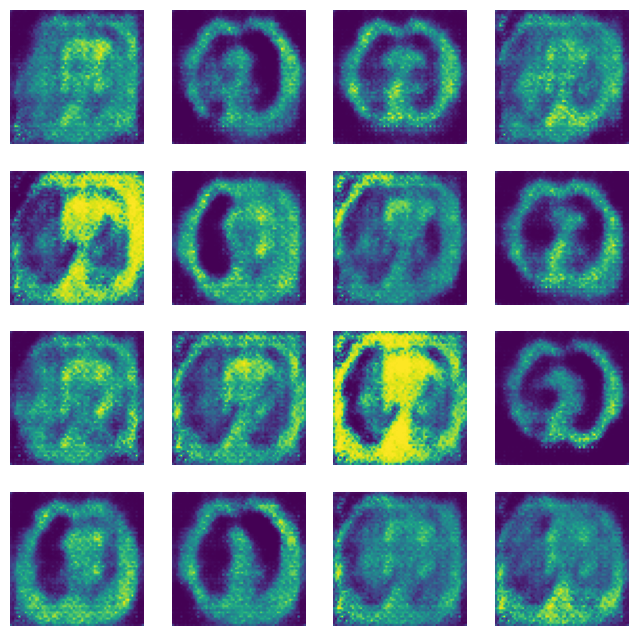

Epoch [17/500], Step [0/16], D Loss: 0.3405, G Loss: 3.8415
Epoch [18/500], Step [0/16], D Loss: 0.6034, G Loss: 5.0885
Epoch [19/500], Step [0/16], D Loss: 0.6826, G Loss: 4.0567
Epoch [20/500], Step [0/16], D Loss: 0.5134, G Loss: 4.8156
Epoch [21/500], Step [0/16], D Loss: 0.3484, G Loss: 2.6835


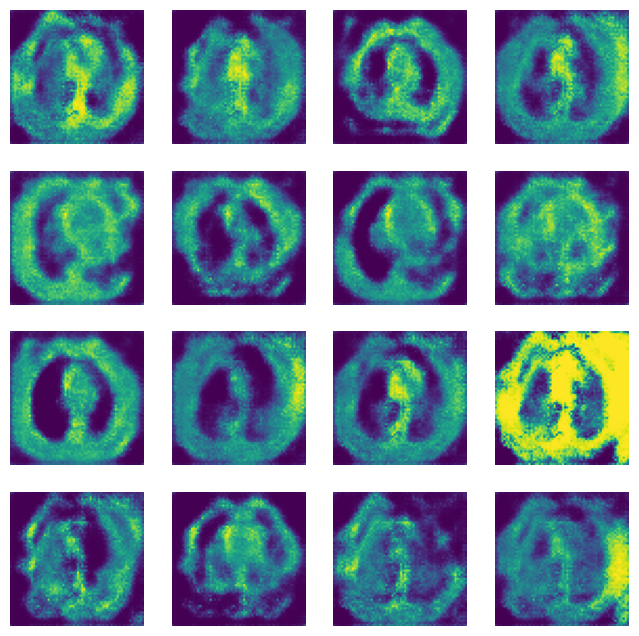

Epoch [22/500], Step [0/16], D Loss: 0.7244, G Loss: 2.3169
Epoch [23/500], Step [0/16], D Loss: 0.2550, G Loss: 1.3085
Epoch [24/500], Step [0/16], D Loss: 0.5522, G Loss: 3.3705
Epoch [25/500], Step [0/16], D Loss: 0.2987, G Loss: 4.1785
Epoch [26/500], Step [0/16], D Loss: 0.7010, G Loss: 8.0987


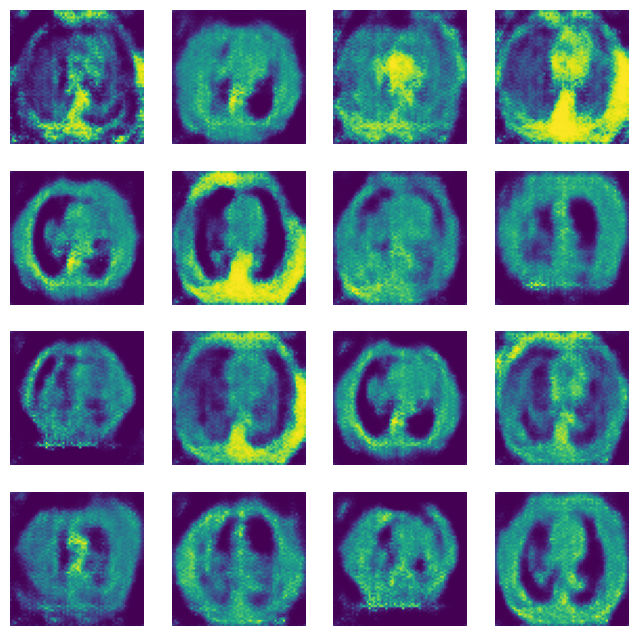

Epoch [27/500], Step [0/16], D Loss: 0.3273, G Loss: 2.7891
Epoch [28/500], Step [0/16], D Loss: 0.6680, G Loss: 2.6198
Epoch [29/500], Step [0/16], D Loss: 0.3129, G Loss: 4.6056
Epoch [30/500], Step [0/16], D Loss: 0.3840, G Loss: 3.5438
Epoch [31/500], Step [0/16], D Loss: 0.5616, G Loss: 6.0657


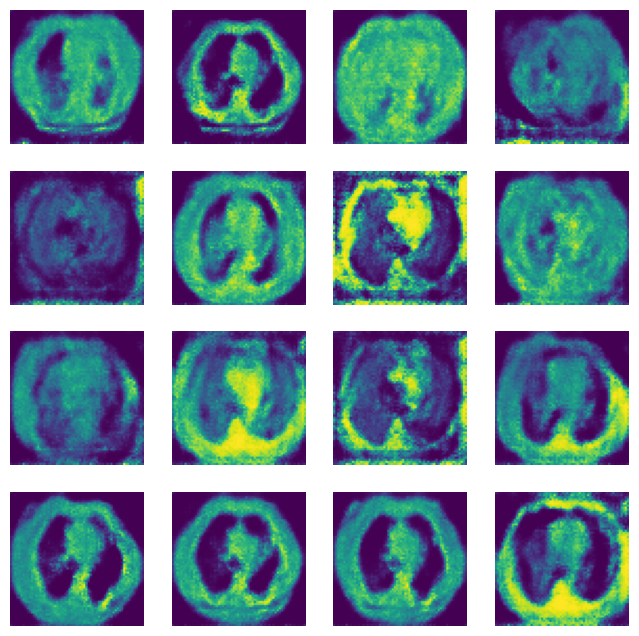

Epoch [32/500], Step [0/16], D Loss: 0.5195, G Loss: 4.6463
Epoch [33/500], Step [0/16], D Loss: 0.2541, G Loss: 4.9036
Epoch [34/500], Step [0/16], D Loss: 0.5856, G Loss: 6.7250
Epoch [35/500], Step [0/16], D Loss: 0.3730, G Loss: 4.8590
Epoch [36/500], Step [0/16], D Loss: 0.2381, G Loss: 4.8509


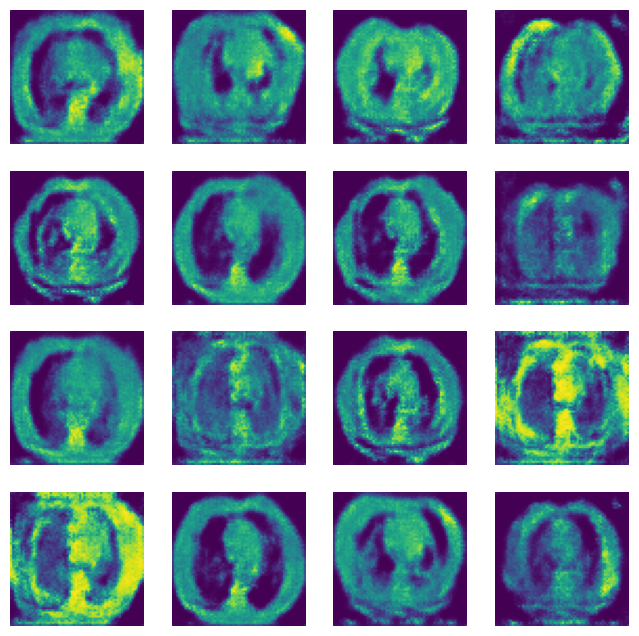

Epoch [37/500], Step [0/16], D Loss: 0.6101, G Loss: 6.4410
Epoch [38/500], Step [0/16], D Loss: 0.2324, G Loss: 3.4667
Epoch [39/500], Step [0/16], D Loss: 0.2739, G Loss: 4.5678
Epoch [40/500], Step [0/16], D Loss: 0.1793, G Loss: 3.0199
Epoch [41/500], Step [0/16], D Loss: 0.2678, G Loss: 4.3876


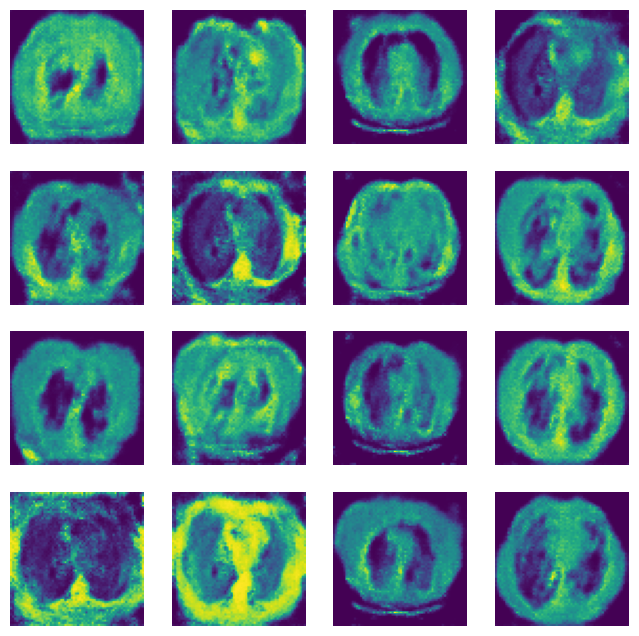

Epoch [42/500], Step [0/16], D Loss: 0.3281, G Loss: 2.9910
Epoch [43/500], Step [0/16], D Loss: 0.4795, G Loss: 2.4477
Epoch [44/500], Step [0/16], D Loss: 0.3273, G Loss: 3.8893
Epoch [45/500], Step [0/16], D Loss: 0.4160, G Loss: 3.2396
Epoch [46/500], Step [0/16], D Loss: 0.3038, G Loss: 2.8453


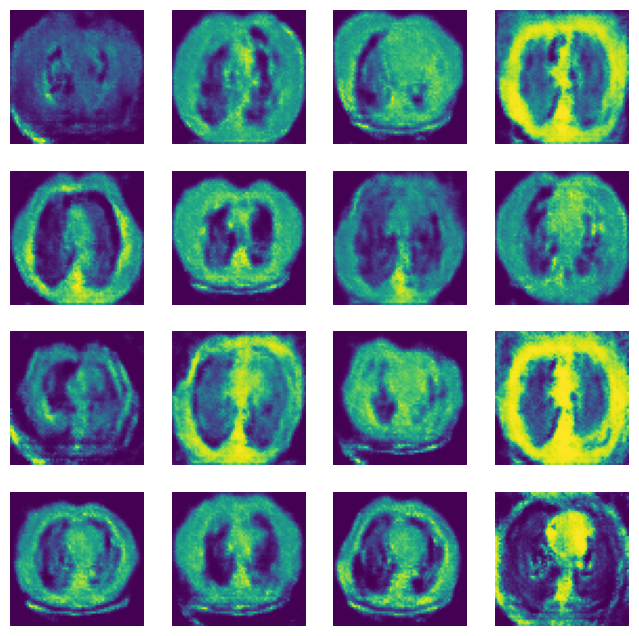

Epoch [47/500], Step [0/16], D Loss: 0.4830, G Loss: 2.6652
Epoch [48/500], Step [0/16], D Loss: 0.2256, G Loss: 3.9732
Epoch [49/500], Step [0/16], D Loss: 0.2666, G Loss: 2.8474
Epoch [50/500], Step [0/16], D Loss: 0.2065, G Loss: 4.1887
Epoch [51/500], Step [0/16], D Loss: 0.3409, G Loss: 3.9028


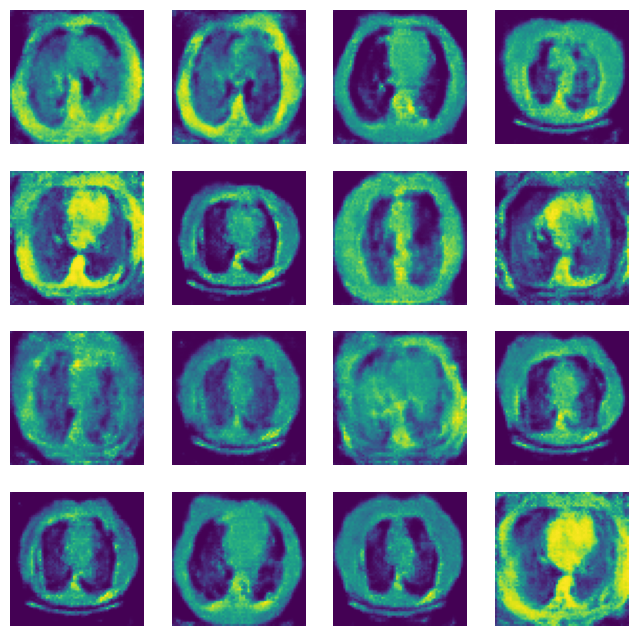

Epoch [52/500], Step [0/16], D Loss: 0.3146, G Loss: 5.0291
Epoch [53/500], Step [0/16], D Loss: 0.3146, G Loss: 4.8323
Epoch [54/500], Step [0/16], D Loss: 0.1328, G Loss: 4.6933
Epoch [55/500], Step [0/16], D Loss: 0.4162, G Loss: 5.9445
Epoch [56/500], Step [0/16], D Loss: 0.4923, G Loss: 4.1321


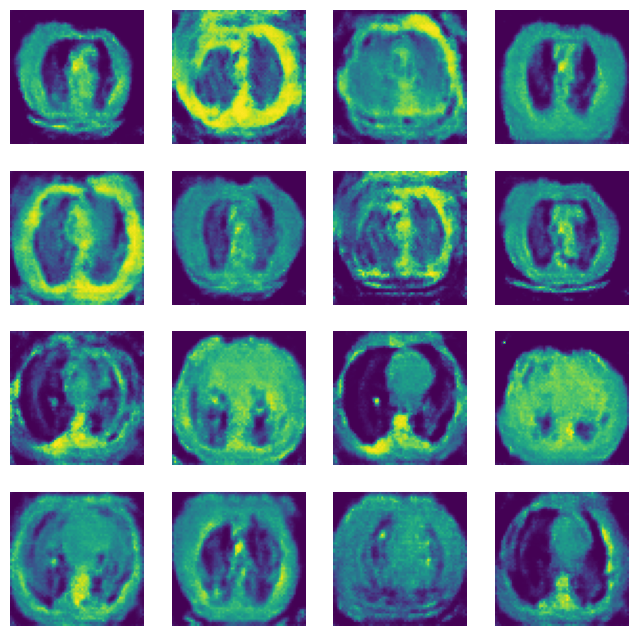

Epoch [57/500], Step [0/16], D Loss: 0.2405, G Loss: 3.6952
Epoch [58/500], Step [0/16], D Loss: 0.1915, G Loss: 4.1765
Epoch [59/500], Step [0/16], D Loss: 0.2462, G Loss: 5.3154
Epoch [60/500], Step [0/16], D Loss: 0.2272, G Loss: 3.1504
Epoch [61/500], Step [0/16], D Loss: 0.3366, G Loss: 5.4249


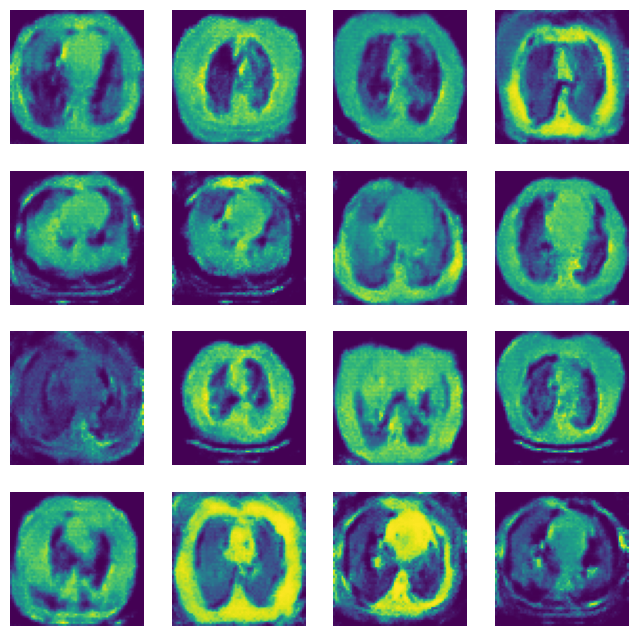

Epoch [62/500], Step [0/16], D Loss: 0.2535, G Loss: 3.4839
Epoch [63/500], Step [0/16], D Loss: 0.7373, G Loss: 5.2109
Epoch [64/500], Step [0/16], D Loss: 0.3328, G Loss: 3.5322
Epoch [65/500], Step [0/16], D Loss: 0.2567, G Loss: 4.9481
Epoch [66/500], Step [0/16], D Loss: 0.2960, G Loss: 4.2143


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_epochs = 500
batch_size = 64
lr = 0.0002
latent_dim = 100

# Re-initialize models and move them to GPU
generator = generator.to(device)
discriminator = discriminator.to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        
        # Move real images to GPU
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        # Create labels
        real_labels = torch.ones(batch_size, 1, device=device)  # Label = 1 for real images
        fake_labels = torch.zeros(batch_size, 1, device=device) # Label = 0 for fake images
        
        # 1. Train Discriminator
        optimizer_D.zero_grad()
        
        # Real images loss
        real_outputs = discriminator(real_images).view(-1, 1)
        real_loss = criterion(real_outputs, real_labels)

        # Fake images loss
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        fake_outputs = discriminator(fake_images.detach()).view(-1, 1)
        fake_loss = criterion(fake_outputs, fake_labels)
        
        # Total discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()
        
        # 2. Train Generator
        optimizer_G.zero_grad()
        
        # Generate fake images and classify them as real
        fake_outputs = discriminator(fake_images).view(-1, 1)
        g_loss = criterion(fake_outputs, real_labels)
        
        # Backpropagation and optimization
        g_loss.backward()
        optimizer_G.step()

        # Print training progress
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    # Generate sample images every few epochs
    if epoch % 5 == 0:
        with torch.no_grad():
            noise = torch.randn(16, latent_dim, 1, 1, device=device)
            sample_images = generator(noise).cpu()
            sample_images = (sample_images + 1) / 2  # Rescale to [0,1]
            
            # Plot generated images
            import matplotlib.pyplot as plt
            import numpy as np
            
            fig, ax = plt.subplots(4, 4, figsize=(8, 8))
            for j in range(16):
                ax[j // 4, j % 4].imshow(np.transpose(sample_images[j].numpy(), (1, 2, 0)))
                ax[j // 4, j % 4].axis("off")
            
            plt.show()


✔ Uses BCELoss to distinguish real vs. fake images.<br>
✔ Updates discriminator and generator separately to maintain balance.<br>
✔ Uses detached fake images (fake_images.detach()) when training the discriminator.<br>
✔ Prints loss values every 100 steps to track training progress.<br>
✔ Generates sample images every 5 epochs to visualize progress.<br>